In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

In [2]:
import matplotlib.pyplot as plt

from datetime import datetime, timedelta, date
from mechafil import data
import pandas as pd
import numpy as np

import copy

from agentfil.filecoin_model import FilecoinModel, solve_geometric, distribute_agent_power_geometric_series
from agentfil.greedy_agent import GreedyAgent
from agentfil import constants
from mechafil import minting, sim

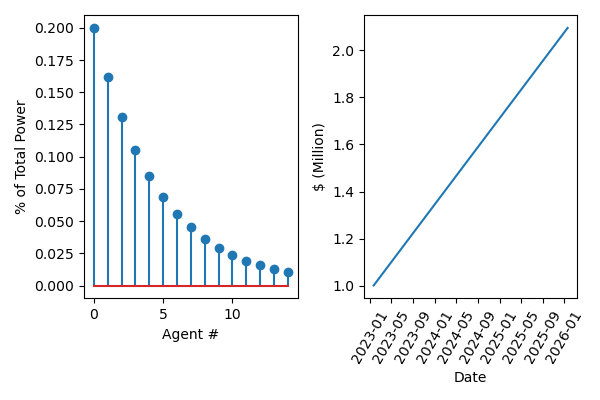

In [3]:
simulation_start_date = datetime.today().date() - timedelta(days=1)
forecast_length = 365*3
end_date = simulation_start_date + timedelta(days=forecast_length)

num_agents = 15
agent_power_distributions = distribute_agent_power_geometric_series(num_agents, a=0.2)

# setup agent capital distributions. Proportion them in the same way as the power
starting_capital_usd = 1_000_000
capital_inflow_rate = 1000
total_capital_vec = np.arange(1,forecast_length+1) * capital_inflow_rate
total_capital_vec = total_capital_vec + starting_capital_usd
total_capital_df = pd.DataFrame({
    'date': pd.date_range(simulation_start_date, end_date, freq='D')[:-1],
    'USD': total_capital_vec
})
agent_accounting_df_vec = []
for ii, agent_power_pct in enumerate(agent_power_distributions):
    agent_accounting_df = total_capital_df.drop('date', axis=1)*agent_power_pct
    agent_accounting_df['date'] = total_capital_df['date']
    agent_accounting_df_vec.append(agent_accounting_df)

plt.figure(figsize=(6,4))

plt.subplot(1,2,1)
plt.stem(agent_power_distributions)
plt.xlabel('Agent #')
plt.ylabel('% of Total Power')

plt.subplot(1,2,2)
plt.plot(total_capital_df['date'], total_capital_df['USD']/starting_capital_usd)
plt.xticks(rotation=60)
plt.xlabel('Date')
plt.ylabel('\$ (Million)')

plt.tight_layout()

In [4]:
agent_types = [GreedyAgent] * num_agents
agent_kwargs_vec = []
for agent_accounting_df in agent_accounting_df_vec:
    kwargs = {
        'accounting_df': agent_accounting_df
    }
    agent_kwargs_vec.append(kwargs)
filecoin_model = FilecoinModel(num_agents, simulation_start_date, end_date, 
                               agent_types, agent_kwargs_vec,
                               compute_cs_from_networkdatastart=True, use_historical_gas=False)

/opt/anaconda3/envs/cel/lib/python3.10/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)
/opt/anaconda3/envs/cel/lib/python3.10/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)
/Users/kiran/code/filecoin-agent-twin/agentfil/greedy_agent.py:65: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non

In [5]:
sim_len = (end_date - simulation_start_date).days
for ii in range(sim_len):
    filecoin_model.step()

/Users/kiran/code/filecoin-agent-twin/agentfil/greedy_agent.py:113: RuntimeWarning: invalid value encountered in double_scalars
  roi_estimate = self.model.filecoin_df.loc[self.model.current_day, 'day_rewards_per_sector'] / self.model.filecoin_df.loc[self.model.current_day, 'day_pledge_per_QAP']


IndexError: index 0 is out of bounds for axis 0 with size 0

In [ ]:
# compare the two
model_df = filecoin_model.filecoin_df

plt.figure(figsize=(8,5))
plt.subplot(2,2,1)
plt.plot(model_df['date'], model_df['total_raw_power_eib'], label='Model(RB)')
plt.plot(model_df['date'], model_df['total_qa_power_eib'], label='Model(QA)')
plt.plot(model_df['date'], model_df['network_baseline'] / 2**60, label='Baseline')
plt.axvline(x=simulation_start_date, color='k', linestyle='--', label='Simulation Start')
plt.legend(fontsize=7)
plt.xticks(rotation=60)
plt.ylabel('EiB')

plt.subplot(2,2,3)
plt.plot(model_df['date'], model_df['day_onboarded_qap_pib'].cumsum(), label='QA')
plt.axvline(x=simulation_start_date, color='k', linestyle='--', label='Simulation Start')
plt.xticks(rotation=60)
plt.title('QA Onboarded')

plt.subplot(2,2,4)
plt.plot(model_df['date'], model_df['day_renewed_qap_pib'].cumsum(), label='QA')
plt.axvline(x=simulation_start_date, color='k', linestyle='--', label='Simulation Start')
plt.xticks(rotation=60)
plt.title('QA Renewed')

plt.tight_layout()

plt.show()

In [ ]:
# from pycoingecko import CoinGeckoAPI
# cg = CoinGeckoAPI()

# change_t = lambda x : datetime.utcfromtimestamp(x/1000).strftime('%Y-%m-%d')
# ts = cg.get_coin_market_chart_range_by_id(id='filecoin',
#                                           vs_currency='usd',
#                                           from_timestamp=time.mktime(constants.NETWORK_DATA_START.timetuple()),
#                                           to_timestamp=time.mktime(simulation_start_date.timetuple()))

In [10]:
exdf = filecoin_model.agents[0]['agent'].usd_fil_exchange_df
exdf['time_d'] = pd.to_datetime(exdf['time_d'])

In [12]:
len(exdf[exdf['time_d'] == simulation_start_date])

0